<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/learn_Gaussian_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:

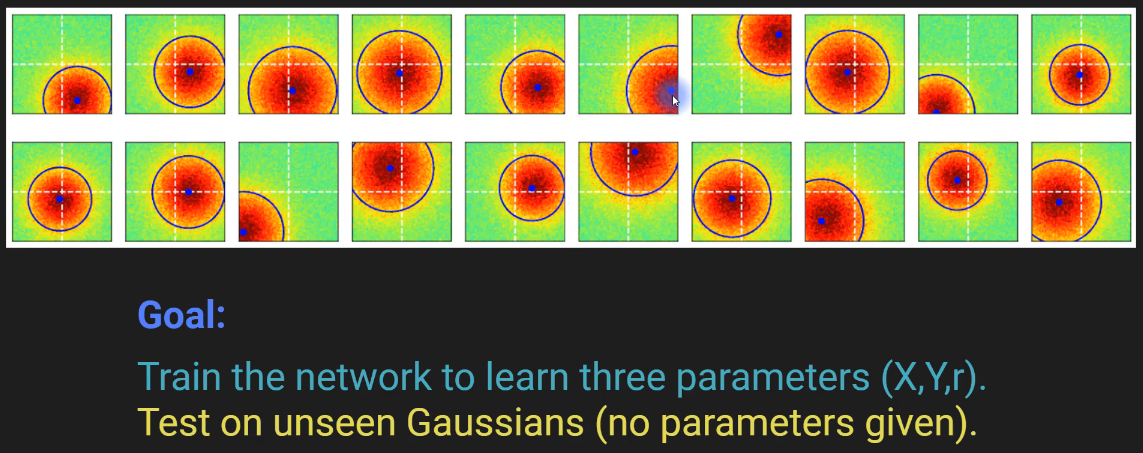

In [50]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [51]:
# scratch:

# np.random.rand() -> generates an array of random numbers between [0,1), following uniform distributions
X1 = np.random.rand(2, 3)
print(X1, "\n")
X2 = np.random.rand(2)
print(X2, "\n")

# np.random.randn() -> generates an array of random numbers following standard normal/Gaussian distribution (mean=0, s.d.=1)
Y1 = np.random.randn(2, 3)
print(Y1, "\n")
Y2 = np.random.randn(2)
print(Y2)

[[0.16930709 0.91817912 0.37980341]
 [0.49509841 0.89913447 0.45131835]] 

[0.06192406 0.11377049] 

[[ 1.81263623  0.64482137  0.21030997]
 [-0.79844872 -0.96982032  0.51266245]] 

[0.82078439 0.92438113]


# Create Gaussian blurs with different s.d.(sigma):

In [52]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)
# tmp = np.meshgrid(x,x) # coordinate grid from the arrays `x` and `x`
# print(tmp, "\n") # `tmp` is a list of 2 elements, each elmt is a 91x91 matrix
# X, Y = tmp[0], tmp[1]
print(X.shape) # (91, 91)
print(Y.shape, "\n") # (91, 91)

# initialize images/labels tensors
images = torch.zeros(nGauss,1,imgSize,imgSize) # (imgs, chans, W, H)
labels = torch.zeros(nGauss,3) # (imgs, 3 params)

for i in range(nGauss):

  # random parameters: C_x, C_y, width (variance, σ^2)
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # σ^2 in [5,15)

  # create the gaussian with random centers
  # variance -> σ^2, s.d. -> σ
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10

  # reshape & add to the images/labels tensors
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] ) # labels with the 3 params (C_x, C_y, width)

(91, 91)
(91, 91) 



In [53]:
print(images.shape)
print(labels.shape)

torch.Size([1000, 1, 91, 91])
torch.Size([1000, 3])


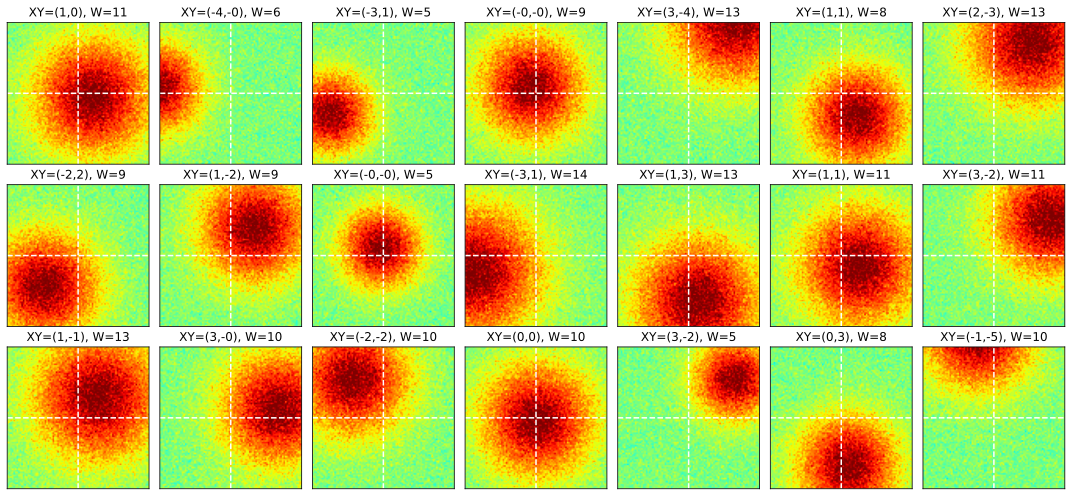

In [54]:
# visualize the results:

fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [55]:
# split data into train/test sets:

# split both the images/labels tensors
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

# np array -> torch Dataset obj (combine)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch DataLoader obj (shuffle)
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([900, 1, 91, 91]) torch.Size([100, 1, 91, 91]) torch.Size([900, 3]) torch.Size([100, 3])


In [56]:
# check sizes:
print( train_loader.dataset.tensors[0].shape ) # data shape
print( train_loader.dataset.tensors[1].shape ) # labels shape

print("")
print( test_loader.dataset.tensors[0].shape ) # data shape
print( test_loader.dataset.tensors[1].shape ) # labels shape

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])

torch.Size([100, 1, 91, 91])
torch.Size([100, 3])


In [57]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(

          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45

          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22

          # linear decision layer
          nn.Flatten(),                # vectorize conv2 output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,3),             # output size: 3
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [58]:
# test the model with one batch:

net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader)) # batch size = 16
yHat = net(X)

# check size of output
print(yHat, "\n")
print(yHat.shape, "\n")

# compute the loss
loss = lossfun(yHat,y)
print('loss:', loss)

tensor([[ 0.0910,  0.0150, -0.1231],
        [ 0.0881,  0.0171, -0.1223],
        [ 0.0879,  0.0158, -0.1223],
        [ 0.0878,  0.0167, -0.1218],
        [ 0.0888,  0.0170, -0.1225],
        [ 0.0878,  0.0161, -0.1216],
        [ 0.0902,  0.0144, -0.1233],
        [ 0.0877,  0.0150, -0.1222],
        [ 0.0877,  0.0157, -0.1218],
        [ 0.0875,  0.0152, -0.1232],
        [ 0.0879,  0.0160, -0.1220],
        [ 0.0880,  0.0158, -0.1220],
        [ 0.0888,  0.0152, -0.1214],
        [ 0.0882,  0.0150, -0.1221],
        [ 0.0877,  0.0158, -0.1217],
        [ 0.0877,  0.0166, -0.1214]], grad_fn=<AddmmBackward0>) 

torch.Size([16, 3]) 

loss: tensor(37.5652, grad_fn=<MseLossBackward0>)


In [59]:
# architecture and total num of params of the model:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [60]:
# a function to train the model:

def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  numepochs = 30

  # initialize
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    batchLoss = []

    # loop over training batches
    for X,y in train_loader:
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    testLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [61]:
# train the model:
trainLoss,testLoss,net = function2trainTheModel()

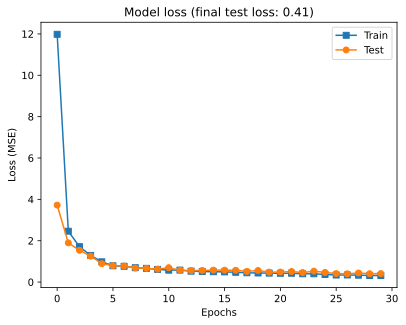

In [62]:
# show the results:

plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

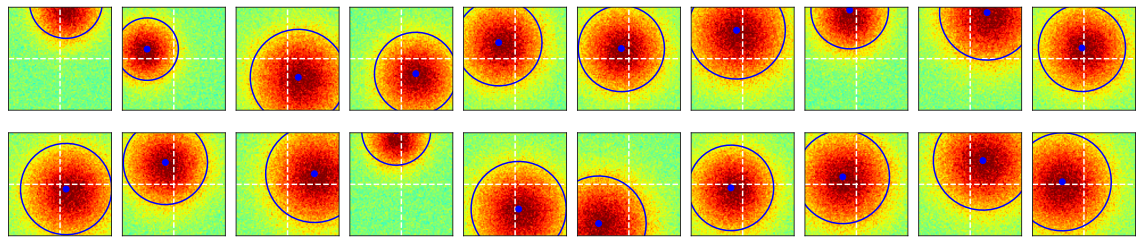

In [63]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)  # th: theta (phase angles)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')

  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

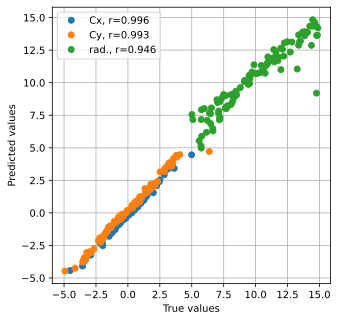

In [64]:
fig = plt.figure(figsize=(5,5))

# show the true parameters & the predicted parameters in a scatter plot:

paramNames = ['Cx','Cy','rad.']

for i in range(3):

  # extract parameters and compute correlation
  yy = Y[:,i].detach()
  yh = yHat[:,i].detach()
  cr = np.corrcoef(yy,yh)[0,1]

  # plot with label
  plt.plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')

plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()